In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy.constants import k as k_B
from scipy.constants import N_A
import seaborn as sns
import plumed

In [2]:
filenm = 'block_analysis/dist-CG.weight' #sys.argv[1]
reference = 'block_analysis/dist-AA.weight' #sys.argv[2]
CG = pd.read_csv(filenm, sep=' ', header=None, names=['dist', 'weight'])
AA = pd.read_csv(reference, sep=' ', header=None, names=['dist', 'weight'])

In [3]:
def compute_potential(CV, weights):
    hist, bins = np.histogram(CV, bins=100, weights=weights, range=(0,4))
    hist[hist==0] = np.min(hist[hist!=0])
    centers = (bins[:-1] + bins[1:]) / 2
    V = -k_B * 300 * np.log(hist)*N_A / 1000
    return centers, V


In [4]:
def  plot_potential(df, axs, nsamples=200, plot_convergence=False, **plotkwargs):
    if plot_convergence:
        for i in range(df.shape[0]//5, df.shape[0]+1, df.shape[0]//5):
            centers, potential = compute_potential(df['dist'][:i], df['weight'][:i])
            axs[0].plot(centers, potential, **plotkwargs)

    errors, bins = [], []
    for nbins in range(1,50,1):
        CVs = np.array_split(df['dist'], nbins)
        weights = np.array_split(df['weight'], nbins)  
        potentials = np.array([compute_potential(CV, weight)[1] for CV, weight in zip(CVs, weights)])
        centers = compute_potential(CVs[0], weights[0])[0]

        #Compute the 95% confidence error in the potential of mean force
        error = np.std(potentials, axis=0) / np.sqrt(nbins) * 1.96
        errors.append(np.mean(error[np.isfinite(error)]))
        bins.append(nbins)

        if abs(nsamples - nbins) == 0:
            #Plot the potential of mean force with 95% confidence interval
            V = compute_potential(df.dist, df.weight)[1] 
            axs[0].plot(centers, V, **plotkwargs)
            axs[0].fill_between(centers, V-error, V +error, alpha=0.5, color=plotkwargs['color'])
            axs[0].set_xlabel('Distance (nm)')
            axs[0].set_ylabel('Potential (kJ/mol)')
            axs[0].set_title('Potential of mean force')
            axs[0].set_xlim(0,2)
            axs[0].set_ylim(-25,20)
    #Print out the distance at which the potential of mean force is minimum
    print(f'{plotkwargs["label"]} minimal distance: {centers[np.argmin(V)]} nm')
    #Print out minimal potential
    print(f'{plotkwargs["label"]} minimal potential: {np.min(V)} kJ/mol')
    axs[1].plot(bins, errors, **plotkwargs)
    axs[1].set_xlabel('Number of bins')
    axs[1].set_ylabel('Error in potential (kJ/mol)')
    axs[1].set_title('Convergence of error potential of mean force')
    axs[0].legend()
    axs[1].legend()
    return axs


CG minimal distance: 0.5800000000000001 nm
CG minimal potential: -17.669479274451273 kJ/mol
AA minimal distance: 0.66 nm
AA minimal potential: -17.360719521738844 kJ/mol


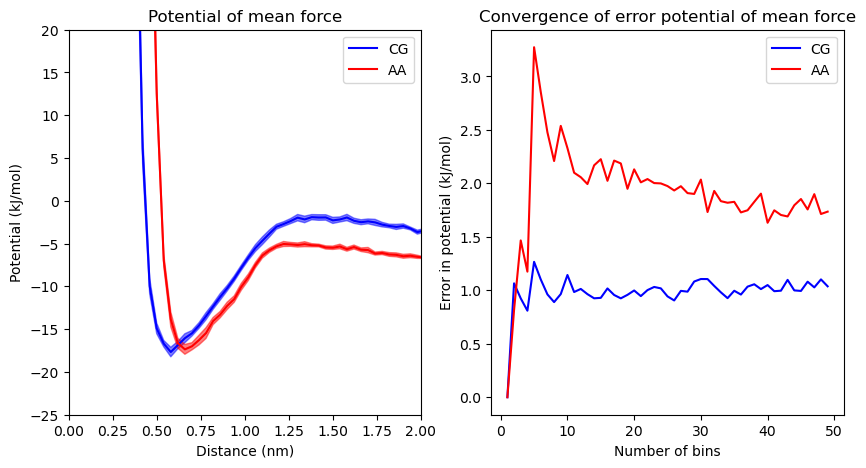

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = plot_potential(CG, axs, color='blue', label='CG', nsamples=10)
axs = plot_potential(AA, axs, color='red', label='AA', nsamples=10)

AA minimal distance: 0.66 nm
AA minimal potential: -17.360719521738844 kJ/mol


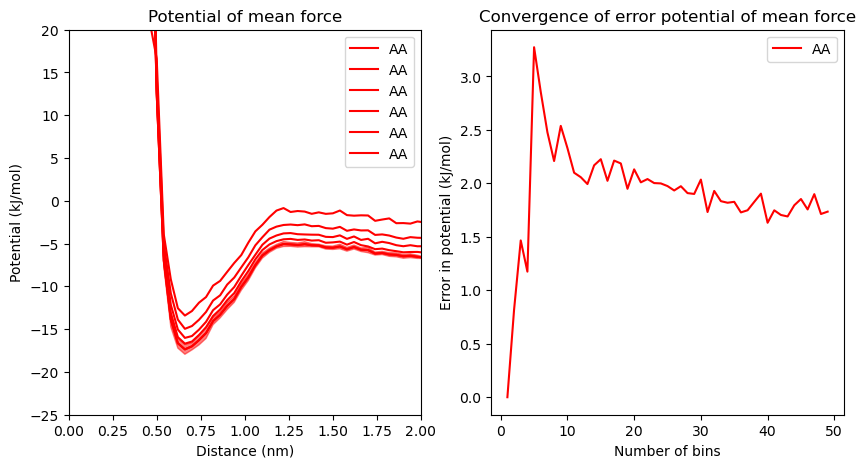

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = plot_potential(AA, axs, color='red', label='AA', nsamples=10, plot_convergence=True)

In [7]:
CVs = plumed.read_as_pandas('AA-reference/HILLS')
CVs.head()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/users_home/makke/miniconda3/envs/molecular-motor/lib/libplumedKernel.so" +++


,time,dist,sigma_dist,height,biasf
0,1,1.978582,0.05,0.222222,10
1,2,1.961867,0.05,0.220358,10
2,3,1.834055,0.05,0.222117,10
3,4,1.868373,0.05,0.220152,10
4,5,1.984009,0.05,0.218351,10


<Axes: xlabel='time', ylabel='dist'>

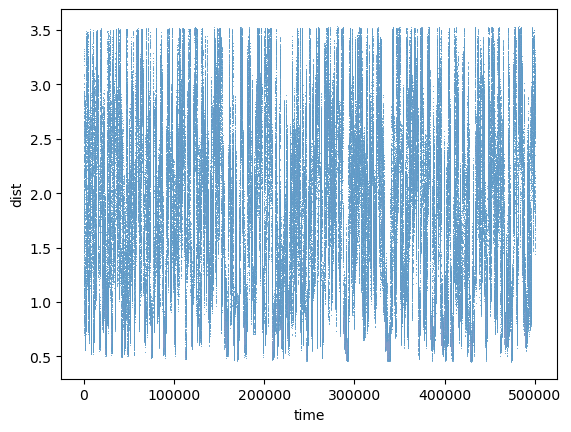

In [8]:
sns.scatterplot(x='time', y='dist', data=CVs, s=0.5)